In [126]:
import pandas as pd
from matplotlib import pyplot as plt
from lib.evaluation import plotEvaluation
from lib.feature_engineering import *

In [150]:
PATH_DATA = '/home/magody/programming/python/ibm_marathona/data/data-science-london-scikit-learn/'

train = pd.read_csv(PATH_DATA+'train.csv', header=None)
trainLabels = pd.read_csv(PATH_DATA+'trainLabels.csv', header=None)
dataset = pd.DataFrame(data=train)
dataset['target'] = trainLabels
dataset = dataset.sample(frac=1)
dataset_len = len(dataset)

X_submission = pd.read_csv(PATH_DATA+'test.csv', header=None)

# Feature engineering

In [151]:
# VARIANCE
low_variance_columns, low_variance_heights = getVarianceLowColumns(dataset, threshold=0.1)
dataset = dataset.drop(low_variance_columns, axis=1)
X = dataset.drop('target', axis=1)
y = dataset['target']
print(len(X.columns), "variance features")

40 variance features


/home/magody/programming/python/ibm_marathona/supervised_learning/lib/feature_engineering.py:46: RuntimeWarning: invalid value encountered in sqrt
  


37 Multicolinearity features


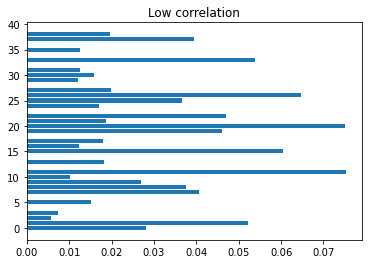

8 with high correlation features [0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 29, 30, 31, 33, 35, 37, 38]
[36, 6, 14, 18, 39, 34]
6 important features


'\nimport pylab as pl\nn_components = int(number_features_to_select * 0.8)\nX_reduced_PCA, pca = reducePCA(X, n_components = 4)\npl.figure(figsize=(12,9))\nax1 = plt.subplot(111)\nax2 = ax1.twinx()\nax1.plot(pca.explained_variance_ratio_, linewidth=2)\nax2.plot(pca.explained_variance_ratio_.cumsum(), linewidth=3, color=\'r\')\nplt.title("PCA")\nplt.show()\nprint(len(X.columns), "n_components features")\n'

In [129]:
# Multicolinearity
multicolinear_columns = getMulticolinearColumns(X.corr(), keep_features_min = 20)
X = X.drop(multicolinear_columns, axis=1)
print(len(X.columns), "Multicolinearity features")

# Low correlation
low_correlations_labels, low_correlations_abs = getLowCorrelationsWithTarget(X, y, min_correlation=0.1)
X = X.drop(low_correlations_labels, axis=1)
plt.barh(low_correlations_labels, low_correlations_abs)
plt.title("Low correlation")
plt.show()
print(len(X.columns), "with high correlation features", low_correlations_labels)

number_features_to_select = int(len(X.columns) * 0.8)

# Important features, the 80% most important
if number_features_to_select > 0 and number_features_to_select < len(X.columns):
    features_important = getImportantFeatures(X, y, number_features_to_select, max_features = 6)
    print(features_important)
    print(number_features_to_select, "important features")
    X = X.loc[:,features_important]
else:
    print("No important features selected")

"""
import pylab as pl
n_components = int(number_features_to_select * 0.8)
X_reduced_PCA, pca = reducePCA(X, n_components = 4)
pl.figure(figsize=(12,9))
ax1 = plt.subplot(111)
ax2 = ax1.twinx()
ax1.plot(pca.explained_variance_ratio_, linewidth=2)
ax2.plot(pca.explained_variance_ratio_.cumsum(), linewidth=3, color='r')
plt.title("PCA")
plt.show()
print(len(X.columns), "n_components features")
"""

In [133]:
z = X.copy()
z['target'] = y
correlation_matrix = z.corr()
correlation_matrix.style.background_gradient(cmap="coolwarm")

,36,6,14,18,39,34,target
36,1.000000,0.090158,-0.114092,-0.042455,-0.046425,0.107606,-0.231733
6,0.090158,1.000000,-0.184330,-0.107176,-0.233928,0.171086,-0.252976
14,-0.114092,-0.184330,1.000000,0.111663,0.092740,0.148442,0.476171
18,-0.042455,-0.107176,0.111663,1.000000,0.300155,-0.033309,0.289508
39,-0.046425,-0.233928,0.092740,0.300155,1.000000,-0.147988,0.264656
34,0.107606,0.171086,0.148442,-0.033309,-0.147988,1.000000,0.236116
target,-0.231733,-0.252976,0.476171,0.289508,0.264656,0.236116,1.000000


In [153]:
amount_for_train = int(dataset_len*0.8)
amount_for_test = dataset_len - amount_for_train

X_train = X.iloc[:amount_for_train, :]
y_train = y.iloc[:amount_for_train]
X_test = X.iloc[amount_for_train:, :]
y_test = y.iloc[amount_for_train:]



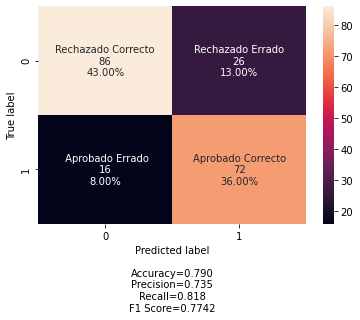

In [136]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train, y_train.values)
plotEvaluation(y_test.values, clf.predict(X_test))

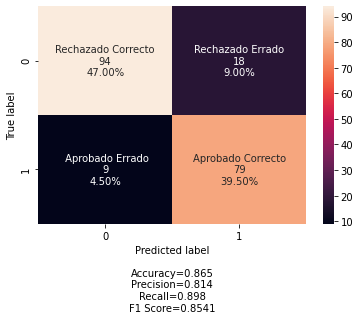

In [139]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train.values)
plotEvaluation(y_test.values, clf.predict(X_test))

0.85


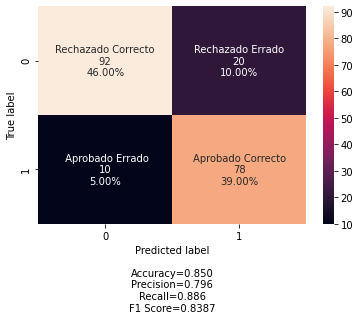

In [138]:
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train.values)
print(clf.score(X_test, y_test.values))
plotEvaluation(y_test.values, clf.predict(X_test))

5


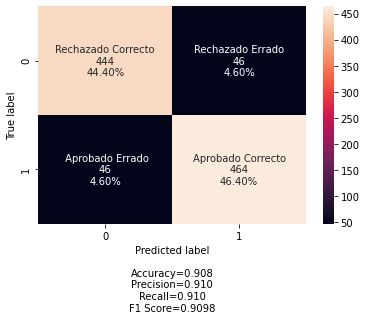

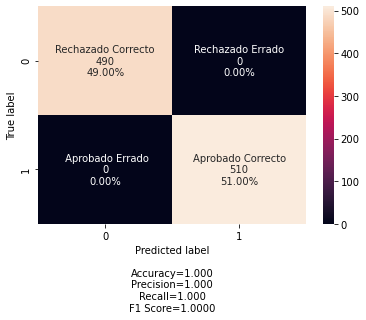

In [146]:
from sklearn.model_selection import GridSearchCV, cross_val_score


knn = KNeighborsClassifier()
rf = RandomForestClassifier()

param_grid = dict()

grid_search_knn = GridSearchCV(knn, param_grid=param_grid, cv=10, scoring='accuracy').fit(X, y)
knn_best = grid_search_knn.best_estimator_
print(knn_best.n_neighbors)
plotEvaluation(y.values, knn_best.predict(X))
plt.show()

grid_search_rf = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring='accuracy').fit(X, y)
rf_best = grid_search_rf.best_estimator_
plotEvaluation(y.values, rf_best.predict(X))
plt.show()

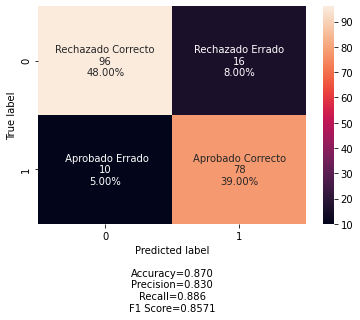

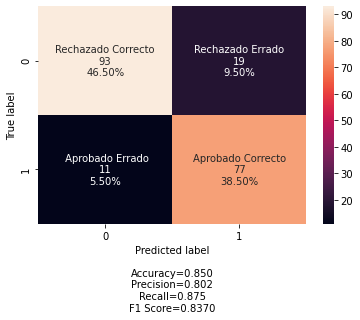

In [148]:
knn_best.fit(X_train, y_train)
rf_best.fit(X_train, y_train)
plotEvaluation(y_test.values, knn_best.predict(X_test))
plt.show()
plotEvaluation(y_test.values, rf_best.predict(X_test))
plt.show()

In [143]:
y_submission = knn_best.predict(X_submission.loc[:, X.columns])
knn_best_pred = pd.DataFrame(data={
    'Id': np.arange(1, len(y_submission) + 1),
    'Solution': y_submission
})
knn_best_pred.to_csv('submission_early.csv', index=False)

In [164]:
from sklearn.mixture import GaussianMixture


X_all = np.concatenate((X.copy().to_numpy(), X_submission), axis=0)

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X_all)
        bic.append(gmm.aic(X_all))
        
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
best_gmm.fit(X_all)

gmm_X_train = best_gmm.predict_proba(X_train)
gmm_X_test = best_gmm.predict_proba(X_test)
gmm_X_submission = best_gmm.predict_proba(X_submission)


In [166]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

param_grid = dict()

grid_search_knn = GridSearchCV(knn, param_grid=param_grid, cv=10, scoring='accuracy').fit(gmm_X_train, y_train)
knn_best = grid_search_knn.best_estimator_

grid_search_rf = GridSearchCV(rf, param_grid=dict(), cv=10, scoring='accuracy').fit(gmm_X_train, y_train)
rf_best = grid_search_rf.best_estimator_

print("Best estimator KNN: ", grid_search_knn.best_estimator_,
     "Best score: ", grid_search_knn.best_estimator_.score(gmm_X_test, y_test))
print("Best estimator RandomForest: ", grid_search_rf.best_estimator_,
     "Best score: ", grid_search_rf.best_estimator_.score(gmm_X_test, y_test))

Best estimator KNN:  KNeighborsClassifier() Best score:  0.99
Best estimator RandomForest:  RandomForestClassifier() Best score:  0.99


In [167]:
knn_best.fit(gmm_X_train, y_train)
rf_best.fit(gmm_X_train, y_train)

print("Score for KNN: ", cross_val_score(knn_best, gmm_X_test, y_test, cv=10, scoring='accuracy').max())
print("Score for Random Forest: ", cross_val_score(rf_best, gmm_X_test, y_test, cv=10, scoring='accuracy').max())

Score for KNN:  1.0
Score for Random Forest:  1.0


In [168]:
y_submission = knn_best.predict(gmm_X_submission)
knn_best_pred = pd.DataFrame(data={
    'Id': np.arange(1, len(y_submission) + 1),
    'Solution': y_submission
})
knn_best_pred.to_csv('submission.csv', index=False)